In [3]:

import pandas as pd
import pickle
import warnings

warnings.filterwarnings('ignore')

# For recommendation algorithms
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
user_path = "../yelp_dataset/yelp_users_with_taste_profile.csv"
rest_path = "../yelp_dataset/yelp_restaurants_filtered_with_new_features.csv"
reviews_path = "../yelp_dataset/yelp_restaurant_reviews_with_vader.csv"

In [5]:
print("Loading data...")
# load reviews
reviews_df = pd.read_csv(reviews_path)

# load businesses
business_df = pd.read_csv(rest_path)

# load users
user_df = pd.read_csv(user_path)

Loading data...


KeyboardInterrupt: 

In [16]:
# 2. Data Filtering and Preprocessing
print("Filtering data for quality recommendations...")

# count reviews per user and business
user_review_counts = reviews_df['user_id'].value_counts()
business_review_counts = reviews_df['business_id'].value_counts()

print(f"\nBefore filtering:")
print(f"Users: {reviews_df['user_id'].nunique():,}")
print(f"Businesses: {reviews_df['business_id'].nunique():,}")
print(f"Reviews: {len(reviews_df):,}")

# filter users with at least 30 reviews
active_users = user_review_counts[user_review_counts >= 30].index
filtered_reviews = reviews_df[reviews_df['user_id'].isin(active_users)]

# filter businesses with at least 50 reviews
popular_businesses = business_review_counts[business_review_counts >= 50].index
filtered_reviews = filtered_reviews[filtered_reviews['business_id'].isin(popular_businesses)]
print(f"\nAfter filtering (>=20 reviews each):")
print(f"Users: {filtered_reviews['user_id'].nunique():,}")
print(f"Businesses: {filtered_reviews['business_id'].nunique():,}")
print(f"Reviews: {len(filtered_reviews):,}")
print(f"Sparsity: {1 - (len(filtered_reviews) / (filtered_reviews['user_id'].nunique() * filtered_reviews['business_id'].nunique())):.4f}")

Filtering data for quality recommendations...

Before filtering:
Users: 1,455,925
Businesses: 59,248
Reviews: 4,881,649

After filtering (>=20 reviews each):
Users: 18,124
Businesses: 21,967
Reviews: 1,032,884
Sparsity: 0.9974


In [17]:
# create working dataset with essential columns
reviews_clean = filtered_reviews[['user_id', 'business_id', 'stars', 'text', 'date']].copy()

# convert date if needed
if 'date' in reviews_clean.columns:
    reviews_clean['date'] = pd.to_datetime(reviews_clean['date'], errors='coerce')

# check for ratings distribution
print("\nRatings distribution:")
print(reviews_clean['stars'].value_counts().sort_index())
print("Preparing data for Surprise library...")

# create surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(reviews_clean[['user_id', 'business_id', 'stars']], reader)

# 80/20 split
trainset, testset = train_test_split(data, test_size=0.2, random_state=23)


Ratings distribution:
stars
1.0     43954
2.0     79901
3.0    177520
4.0    370012
5.0    361497
Name: count, dtype: int64
Preparing data for Surprise library...


In [19]:
print("Building content-based features...")
# filter business data to only include businesses in our dataset
filtered_business_df = business_df[business_df['business_id'].isin(filtered_reviews['business_id'].unique())].copy()

print(f"\nFiltered businesses: {len(filtered_business_df):,}")
# define numeric columns for business features (these will be used for similarity)
business_numeric_cols = ['latitude', 'longitude', 'stars', 'review_count',
                         'num_tips', 'num_checkins', 'RestaurantsPriceRange2',
                         'avg_sentiment', 'local_preference_ratio', 'elite_user_ratio']

# define categorical columns for business features
business_categorical_cols = ['city', 'state', 'is_open',
                             'has_coffee_or_tea', 'serves_sweets',
                             'serves_alcohol', 'DogsAllowed', 'has_european_food',
                             'has_american', 'has_asian_food', 'has_seafood',
                             'has_entertainment', 'has_hispanic_food',
                             'has_vegetarian', 'Open24Hours']

# info columns to preserve (not encode)
business_info_cols = ['business_id', 'name', 'address', 'categories']

# check which columns actually exist
available_numeric = [col for col in business_numeric_cols if col in filtered_business_df.columns]
available_categorical = [col for col in business_categorical_cols if col in filtered_business_df.columns]
available_info = [col for col in business_info_cols if col in filtered_business_df.columns]

print(f"Available numeric features: {len(available_numeric)}")
print(f"Available categorical features: {len(available_categorical)}")
print(f"Available info columns: {len(available_info)}")

# extract business features - keep original business_id separate
business_features = filtered_business_df[['business_id'] + available_numeric + available_categorical].copy()
business_features[available_numeric] = business_features[available_numeric].fillna(0)
business_features = business_features.fillna(0)

# scale numeric business columns
scaler_business = StandardScaler()
business_features[available_numeric] = scaler_business.fit_transform(
    business_features[available_numeric]
)


# store original business_id before encoding
business_id_mapping = business_features['business_id'].copy()

# encode categorical variables using label encoding (except business_id)
for col in available_categorical:
    if col in business_features.columns:
        business_features[col] = business_features[col].astype('category').cat.codes
print("Any NaNs in business_features:", business_features.isna().any().any())


Building content-based features...

Filtered businesses: 21,967
Available numeric features: 10
Available categorical features: 15
Available info columns: 4
Any NaNs in business_features: False


In [20]:
# define user feature cols
user_numeric_cols = [
    'review_count', 'useful', 'funny', 'cool', 'fans', 'average_stars',
    'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute',
    'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool',
    'compliment_funny', 'compliment_writer', 'compliment_photos',
    'avg_sentiment', 'top_category_ratio', 'has_american_ratio',
    'has_asian_food_ratio', 'has_hispanic_food_ratio', 'has_european_food_ratio',
    'has_seafood_ratio', 'serves_alcohol_ratio', 'has_vegetarian_ratio',
    'has_entertainment_ratio', 'has_coffee_or_tea_ratio', 'serves_sweets_ratio',
    'years_elite', 'rating_variance', 'local_review_ratio',
    'days_since_last_review', 'review_frequency', 'avg_price_preference',
    'num_cities_reviewed'
]

In [21]:
# cat columns that need encoding
user_categorical_cols = [
    'base_city',  # city where user is based
    'state_code',  # state code
    'top_category',  # user's most reviewed category
    'elite'  # whether user is elite (if not already binary)
]

# date col (needs special handling)
user_date_cols = ['yelping_since']
# prep user features with encoding
user_features_prepared = user_df[['user_id']].copy()

# add numeric features directly
available_user_numeric = [col for col in user_numeric_cols if col in user_df.columns]
user_features_prepared[available_user_numeric] = user_df[available_user_numeric].fillna(0)

# scale numeric cols
scaler_user = StandardScaler()
user_features_prepared[available_user_numeric] = scaler_user.fit_transform(user_features_prepared[available_user_numeric])

In [22]:
# encode categorical features
available_user_categorical = [col for col in user_categorical_cols if col in user_df.columns]

for col in available_user_categorical:
    # label encoding (converts categories to numeric codes)
    user_features_prepared[f'{col}_encoded'] = user_df[col].astype('category').cat.codes

# handle date feature (convert to days since first review)
if 'yelping_since' in user_df.columns:
    user_df['yelping_since'] = pd.to_datetime(user_df['yelping_since'], errors='coerce')
    reference_date = user_df['yelping_since'].max()
    user_features_prepared['days_yelping'] = (reference_date - user_df['yelping_since']).dt.days

if 'days_yelping' in user_features_prepared.columns:
    user_features_prepared['days_yelping'] = user_features_prepared['days_yelping'].fillna(0)


user_features_prepared['days_yelping'] = scaler_user.fit_transform(
     user_features_prepared['days_yelping'].values.reshape(-1, 1))
user_features_prepared = user_features_prepared.fillna(0)

print(f"User features shape: {user_features_prepared.shape}")
print("Any NaNs in user_features_prepared:", user_features_prepared.isna().any().any())

print(f"User features shape: {user_features_prepared.shape}")
print(f"Columns: {user_features_prepared.columns.tolist()}")

User features shape: (1987897, 42)
Any NaNs in user_features_prepared: False
User features shape: (1987897, 42)
Columns: ['user_id', 'review_count', 'useful', 'funny', 'cool', 'fans', 'average_stars', 'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 'compliment_writer', 'compliment_photos', 'avg_sentiment', 'top_category_ratio', 'has_american_ratio', 'has_asian_food_ratio', 'has_hispanic_food_ratio', 'has_european_food_ratio', 'has_seafood_ratio', 'serves_alcohol_ratio', 'has_vegetarian_ratio', 'has_entertainment_ratio', 'has_coffee_or_tea_ratio', 'serves_sweets_ratio', 'years_elite', 'rating_variance', 'local_review_ratio', 'days_since_last_review', 'review_frequency', 'avg_price_preference', 'num_cities_reviewed', 'base_city_encoded', 'state_code_encoded', 'top_category_encoded', 'elite_encoded', 'days_yelping']


In [63]:
user_features_prepared

,user_id,review_count,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,...,local_review_ratio,days_since_last_review,review_frequency,avg_price_preference,num_cities_reviewed,base_city_encoded,state_code_encoded,top_category_encoded,elite_encoded,days_yelping
0,qVc8ODYU5SZjKXVBgXdI7w,6.801819,11.184602,3.045658,10.560175,14.645521,0.236201,3.372103,5.045570,3.617273,...,0.0,-0.755611,0.0,0.688483,2.384843,108,2,7,97,2.486500
1,j14WgRoU_-2ZE1aw1dXrJg,52.195273,67.108366,31.998339,48.212880,172.995302,0.092540,15.532128,20.562546,12.129176,...,0.0,-0.848747,0.0,0.579100,2.384843,616,15,7,419,1.840157
2,2WnXYQFK0hXEoTxPtV2zvg,7.770729,3.185917,2.435070,1.732033,2.787213,-0.262389,1.184657,0.990883,0.648005,...,0.0,2.645236,0.0,0.579100,0.386315,660,14,6,408,2.002848
3,SZDeASXq7o05mMNLshsdIA,2.429611,0.732218,0.767599,0.486790,1.463495,0.540426,0.301527,0.289110,0.054152,...,0.0,3.228470,0.0,0.551754,1.052491,548,9,57,404,2.859628
4,hA5lMy-EnncsH4JoR-hFGQ,0.673460,-0.020728,-0.004832,-0.029704,-0.025688,-0.076474,-0.010965,0.055186,-0.011832,...,0.0,-0.713111,0.0,0.986799,1.718667,68,6,207,-1,2.503300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987892,fB3jbHi3m0L2KgGOxBv6uw,-0.004777,-0.055023,-0.041615,-0.042085,-0.080843,1.089720,-0.024552,-0.022789,-0.011832,...,0.0,0.291499,0.0,0.688483,-0.279860,616,15,184,-1,-0.080304
1987893,68czcr4BxJyMQ9cJBm6C7Q,-0.271227,-0.065936,-0.041615,-0.042085,-0.080843,1.157326,-0.024552,-0.022789,-0.011832,...,0.0,-0.155195,0.0,0.688483,-0.279860,694,4,302,-1,-0.544503
1987894,1x3KMskYxOuJCjRz70xOqQ,-0.234893,-0.064377,-0.039162,-0.042085,-0.080843,-1.377878,-0.024552,-0.022789,-0.011832,...,0.0,0.641440,0.0,1.782309,-0.279860,541,16,290,-1,-0.752288
1987895,ulfGl4tdbrH05xKzh5lnog,-0.259116,-0.065936,-0.041615,-0.042085,-0.080843,-0.532810,-0.024552,-0.022789,-0.011832,...,0.0,-0.994330,0.0,-1.499171,-0.279860,387,15,-1,-1,1.204424


In [2]:
user_features_prepared.columns.tolist()

NameError: name 'user_features_prepared' is not defined

In [30]:
from surprise import AlgoBase, PredictionImpossible
import numpy as np
from collections import defaultdict
from yr_old.timer import timeit
from tqdm import tqdm


class HybridRecommender(AlgoBase):

    def __init__(self, n_factors=100, n_epochs=10, lr=0.005, reg=0.02, user_features=None, loc_features=None, alpha=1e-3, beta=1e-3,
                 lr_W=None, user_feat_matrix=None, loc_feat_matrix=None,):
        """
        Parameters:
        - n_factors: number of latent factors
        - n_epochs: training iterations
        - lr: learning rate (for MF part: pu, qi, biases)
        - reg: regularization coefficient for MF part
        - user_features: DataFrame with user features
        - loc_features: DataFrame with business features
        - alpha: weight for user features
        - beta: weight for item features
        - lr_W: learning rate for Wu/Wi (if None, defaults to lr/10)
        """
        AlgoBase.__init__(self)
        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.lr = lr
        self.lr_W = lr_W if lr_W is not None else lr / 10.0  # smaller LR for feature matrices
        self.reg = reg
        self.reg_W = 0.01
        self.alpha = alpha
        self.beta = beta

        self.user_features_df = user_features
        self.loc_features_df = loc_features
        self.cached_user_feat_matrix = user_feat_matrix
        self.cached_loc_feat_matrix = loc_feat_matrix

    @timeit("fit recommender")
    def fit_and_track(self, trainset):
        AlgoBase.fit(self, trainset)

        # init latent factors
        self.pu = np.random.normal(0, 0.1, (trainset.n_users, self.n_factors))
        self.qi = np.random.normal(0, 0.1, (trainset.n_items, self.n_factors))

        # init biases
        self.bu = np.zeros(trainset.n_users)
        self.bi = np.zeros(trainset.n_items)
        self.global_mean = trainset.global_mean

        # prep feature matrices
        self._prepare_features(trainset)

        # ---- training history ----
        self.history = {"epoch": [], "train_rmse": [], "train_mae": []}

        clip_val = 5.0
        clip_val_W = 5.0

        for epoch in tqdm(range(self.n_epochs), leave=False):
            sq_errors = []
            abs_errors = []
            idx = 0
            for u, i, r in trainset.all_ratings():
                # remove after testing
                # if idx == 500:
                #     break
                pred = self._get_prediction(u, i)

                if not np.isfinite(pred):
                    print(f"Non-finite pred at epoch {epoch}, u={u}, i={i}")
                    print("pu[u]:", self.pu[u])
                    print("qi[i]:", self.qi[i])
                    raise ValueError("Non-finite prediction")

                err = r - pred
                sq_errors.append(err ** 2)
                abs_errors.append(abs(err))

                # update latent factors MF part
                temp_pu = self.pu[u].copy()
                self.pu[u] += self.lr * (err * self.qi[i] - self.reg * self.pu[u])
                self.qi[i] += self.lr * (err * temp_pu - self.reg * self.qi[i])

                # clip to prevent gradient explosion
                self.pu[u] = np.clip(self.pu[u], -clip_val, clip_val)
                self.qi[i] = np.clip(self.qi[i], -clip_val, clip_val)

                # update biases
                self.bu[u] += self.lr * (err - self.reg * self.bu[u])
                self.bi[i] += self.lr * (err - self.reg * self.bi[i])

                # update feature projection matrices
                if self.has_user_features and self.alpha > 0.0:
                    grad_Wu = (np.outer(self.user_feat_matrix[u], err * self.qi[i] * self.alpha) - self.reg_W * self.Wu)
                    self.Wu += self.lr_W * grad_Wu
                    # clip after each update (if performance is OK)
                    self.Wu = np.clip(self.Wu, -clip_val_W, clip_val_W)

                if self.has_loc_features and self.beta > 0.0:
                    grad_Wi = (np.outer(self.loc_feat_matrix[i], err *self.pu[u] * self.beta) - self.reg_W *self.Wi)
                    self.Wi += self.lr_W * grad_Wi
                    self.Wi = np.clip(self.Wi, -clip_val_W, clip_val_W)
                idx += 1

            # end-of-epoch metrics
            if len(sq_errors) == 0:
                epoch_rmse = np.nan
                epoch_mae = np.nan
            else:
                epoch_rmse = np.sqrt(np.mean(sq_errors))
                epoch_mae = np.mean(abs_errors)

            self.history["epoch"].append(epoch + 1)
            self.history["train_rmse"].append(epoch_rmse)
            self.history["train_mae"].append(epoch_mae)

        return self

    @timeit("prepare user and restaurant features")
    def _prepare_features(self, trainset):
        """Prepare and normalize feature matrices"""

        # use cached features if available
        if self.cached_user_feat_matrix is not None:
            self.user_feat_matrix = np.nan_to_num(self.cached_user_feat_matrix, nan=0.0)
            self.has_user_features = True
            n_user_feats = self.user_feat_matrix.shape[1]
            self.Wu = np.random.normal(0, 0.1, (n_user_feats, self.n_factors))

        elif self.user_features_df is not None:
            user_feat_cols = [col for col in self.user_features_df.columns if col != 'user_id']
            self.user_feat_matrix = np.zeros((trainset.n_users, len(user_feat_cols)))

            user_dict = (self.user_features_df.set_index('user_id')[user_feat_cols].to_dict('index'))

            for inner_uid in range(trainset.n_users):
                raw_uid = trainset.to_raw_uid(inner_uid)
                if raw_uid in user_dict:
                    self.user_feat_matrix[inner_uid] = list(user_dict[raw_uid].values())

            self.user_feat_matrix = np.nan_to_num(self.user_feat_matrix, nan=0.0)

            self.Wu = np.random.normal(0, 0.1, (len(user_feat_cols), self.n_factors))
            self.has_user_features = True

        else:
            self.has_user_features = False
            self.user_feat_matrix = None
            self.Wu = None

        # business featurews
        if self.cached_loc_feat_matrix is not None:
            self.loc_feat_matrix = np.nan_to_num(self.cached_loc_feat_matrix, nan=0.0)
            self.has_loc_features = True
            n_loc_feats = self.loc_feat_matrix.shape[1]
            self.Wi = np.random.normal(0, 0.1, (n_loc_feats, self.n_factors))

        elif self.loc_features_df is not None:
            loc_feat_cols = [col for col in self.loc_features_df.columns if col != 'business_id']
            self.loc_feat_matrix = np.zeros((trainset.n_items, len(loc_feat_cols)))

            loc_dict = (self.loc_features_df.set_index('business_id')[loc_feat_cols].to_dict('index'))

            for inner_iid in range(trainset.n_items):
                raw_iid = trainset.to_raw_iid(inner_iid)
                if raw_iid in loc_dict:
                    self.loc_feat_matrix[inner_iid] = list(loc_dict[raw_iid].values())

            # again
            self.loc_feat_matrix = np.nan_to_num(self.loc_feat_matrix, nan=0.0)

            self.Wi = np.random.normal(0, 0.1, (len(loc_feat_cols), self.n_factors))
            self.has_loc_features = True
        else:
            self.has_loc_features = False
            self.loc_feat_matrix = None
            self.Wi = None

    def _get_prediction(self, u, i):
        """Calculate prediction for user u and location (restaurant) i"""
        pred = self.global_mean + self.bu[u] + self.bi[i]

        # collaborative filtering component
        pred += np.dot(self.pu[u], self.qi[i])

        # user feature component
        if self.has_user_features and self.alpha > 0.0:
            user_latent_from_feats = self.user_feat_matrix[u] @ self.Wu
            pred += self.alpha * np.dot(user_latent_from_feats, self.qi[i])

        # loc feature component
        if self.has_loc_features and self.beta > 0.0:
            loc_latent_from_feats = self.loc_feat_matrix[i] @ self.Wi
            pred += self.beta * np.dot(self.pu[u], loc_latent_from_feats)

        return pred

    def estimate(self, u, i):
        """Estimate rating for user u and loc i"""
        if not self.trainset.knows_user(u) or not self.trainset.knows_item(i):
            raise PredictionImpossible("User or item unknown")

        return self._get_prediction(u, i)




In [31]:
hybrid = HybridRecommender(
    n_factors=50,
    n_epochs=5,
    lr=0.005,
    reg = 0.02,
    user_features=user_features_prepared,
    loc_features=business_features,
    alpha=1e-3,
    beta=1e-3,)

# train
print("Training model...")
hybrid.fit_and_track(trainset)


Training model...
Elapsed time [prepare user and restaurant features]: 0m 10.40s


Elapsed time [fit recommender]: 2m 15.40s


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [26]:
def evaluate_model(predictions):
    """Comprehensive evaluation metrics"""
    y_true = [pred.r_ui for pred in predictions]
    y_pred = [pred.est for pred in predictions]

    # basic metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # precision@k and recall@k
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = []
        recalls = []

        for uid, user_ratings in user_est_true.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
            n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                                  for (est, true_r) in user_ratings[:k])

            precisions.append(n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0)
            recalls.append(n_rel_and_rec_k / n_rel if n_rel != 0 else 0)

        return np.mean(precisions), np.mean(recalls)

    result_dict = {'RMSE': rmse, 'MAE': mae, 'Precision@5': None, 'Recall@5': None,
                   'Precision@10': None, 'Recall@10': None, 'Precision@20': None, 'Recall@20': None,}
    # update metrics dict
    for k in [5, 10, 20, 30, 50]:
        precision, recall = precision_recall_at_k(predictions, k=k)
        if k == 5:
            result_dict['Precision@5'] = precision
            result_dict['Recall@5'] = recall

        elif k ==10:
            result_dict['Recall@10'] = recall
            result_dict['Precision@10'] = precision

        elif k == 20:
            result_dict['Precision@20'] = precision
            result_dict['Recall@20'] = recall

        elif k == 30:
            result_dict['Precision@30'] = precision
            result_dict['Recall@30'] = recall

        else:
            result_dict['Precision@50'] = precision
            result_dict['Recall@50'] = recall

    return result_dict


In [32]:
preds = hybrid.test(testset)
r = evaluate_model(preds)
r

{'RMSE': 0.9869361944261617,
 'MAE': 0.7723092600681472,
 'Precision@5': 0.7774316879479668,
 'Recall@5': 0.6013302408225407,
 'Precision@10': 0.749883152457637,
 'Recall@10': 0.7937925924053102,
 'Precision@20': 0.7387672435752058,
 'Recall@20': 0.8666156224397269,
 'Precision@30': 0.736213513976508,
 'Recall@30': 0.8798721035208513,
 'Precision@50': 0.7351440935068903,
 'Recall@50': 0.8854767441860387}

In [29]:
preds[:3]

[Prediction(uid='N5fd36xJuEEHAHLHFirVCg', iid='bbzD8rZl3i-NTzernYkxig', r_ui=4.0, est=4.070034487014138, details={'was_impossible': False}),
 Prediction(uid='PZc2H9Mn6Fp5QyAKRb6ybA', iid='D4spXIMXev6pFUz3df31fQ', r_ui=5.0, est=3.8709294583938845, details={'was_impossible': False}),
 Prediction(uid='Byog9k35hMURW_O1dIteHw', iid='_m0mp3Wjcteysto6azQ9iA', r_ui=5.0, est=3.9867583464070884, details={'was_impossible': False})]

In [35]:
# extract the computed matrices (load these in instead of recomputing to save time)
cached_user_matrix = hybrid.user_feat_matrix
cached_loc_matrix = hybrid.loc_feat_matrix

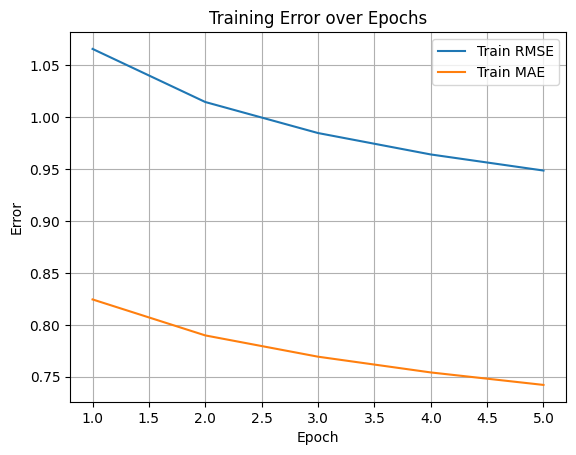

In [33]:
import matplotlib.pyplot as plt

epochs = hybrid.history["epoch"]
rmse = hybrid.history["train_rmse"]
mae = hybrid.history["train_mae"]

plt.figure()
plt.plot(epochs, rmse, label="Train RMSE")
plt.plot(epochs, mae, label="Train MAE")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training Error over Epochs")
plt.legend()
plt.grid(True)
plt.show()

#### Hyperparameter Tuning - Grid Search

In [37]:
# this is after lowering learning rate and increasing the regularization. doing these two things helped
# with the exploding gradient, I was getting errors upwards of 1e+168

# compute features once before grid search
param_grid2 = {
    # 'n_factors': [50],
    'alpha': [0.001, 0.01, 0.1],
    'beta': [0.003, 0.01],}

total_iterations = len(param_grid2['alpha']) * len(param_grid2['beta'])

gs_results2 = []
best_rmse2 = float('inf')
best_params2 = None
best_model = None

print(f"\nStarting grid search ({total_iterations} iterations)...")

# now use cached matrices in grid search
# for n_factors in param_grid2['n_factors']:
for alpha in param_grid2['alpha']:
    for beta in param_grid2['beta']:
        model = HybridRecommender(
            n_factors=50,
            lr=0.0005,
            reg = 0.05,
            user_feat_matrix=cached_user_matrix,  # Use cached
            loc_feat_matrix=cached_loc_matrix,    # Use cached
            alpha=alpha,
            beta=beta)
        model.fit_and_track(trainset)

        # evaluate
        preds = model.test(testset)
        rmse = accuracy.rmse(preds, verbose=False)

        # store gs results
        gs_data={}
        gs_data['alpha'] = alpha
        gs_data['beta'] = beta
        gs_data['rmse'] = rmse
        gs_results2.append(gs_data)


        # track best results
        if rmse < best_rmse2:
            best_rmse2 = rmse
            best_params2 = {'n_factors': 50, 'alpha': alpha, 'beta': beta}
            print(f" New best RMSE: {best_rmse2:.4f} with {best_params2}")
            best_model = model

print(f"\n{'='*50}")
print(f"Best RMSE: {best_rmse2:.4f}")
print(f"Best params: {best_params2}")
results_df = pd.DataFrame(gs_results2)


Starting grid search (6 iterations)...
Elapsed time [prepare user and restaurant features]: 0m 0.01s


Elapsed time [fit recommender]: 4m 5.56s
✓ New best RMSE: 1.0432 with {'n_factors': 50, 'alpha': 0.001, 'beta': 0.003}
Elapsed time [prepare user and restaurant features]: 0m 0.01s


Elapsed time [fit recommender]: 3m 47.71s
Elapsed time [prepare user and restaurant features]: 0m 0.00s


Elapsed time [fit recommender]: 3m 47.72s
Elapsed time [prepare user and restaurant features]: 0m 0.00s


Elapsed time [fit recommender]: 3m 57.01s
Elapsed time [prepare user and restaurant features]: 0m 0.00s


Elapsed time [fit recommender]: 3m 47.84s
Elapsed time [prepare user and restaurant features]: 0m 0.00s


Elapsed time [fit recommender]: 4m 2.83s

Best RMSE: 1.0432
Best params: {'n_factors': 50, 'alpha': 0.001, 'beta': 0.003}


In [38]:
gs_results2

[{'alpha': 0.001, 'beta': 0.003, 'rmse': 1.0431784160850757},
 {'alpha': 0.001, 'beta': 0.01, 'rmse': 1.0436560560272072},
 {'alpha': 0.01, 'beta': 0.003, 'rmse': 1.0440023611907887},
 {'alpha': 0.01, 'beta': 0.01, 'rmse': 1.0442208814317957},
 {'alpha': 0.1, 'beta': 0.003, 'rmse': 1.152231535145557},
 {'alpha': 0.1, 'beta': 0.01, 'rmse': 1.1567337615751372}]

In [55]:
import seaborn as sns

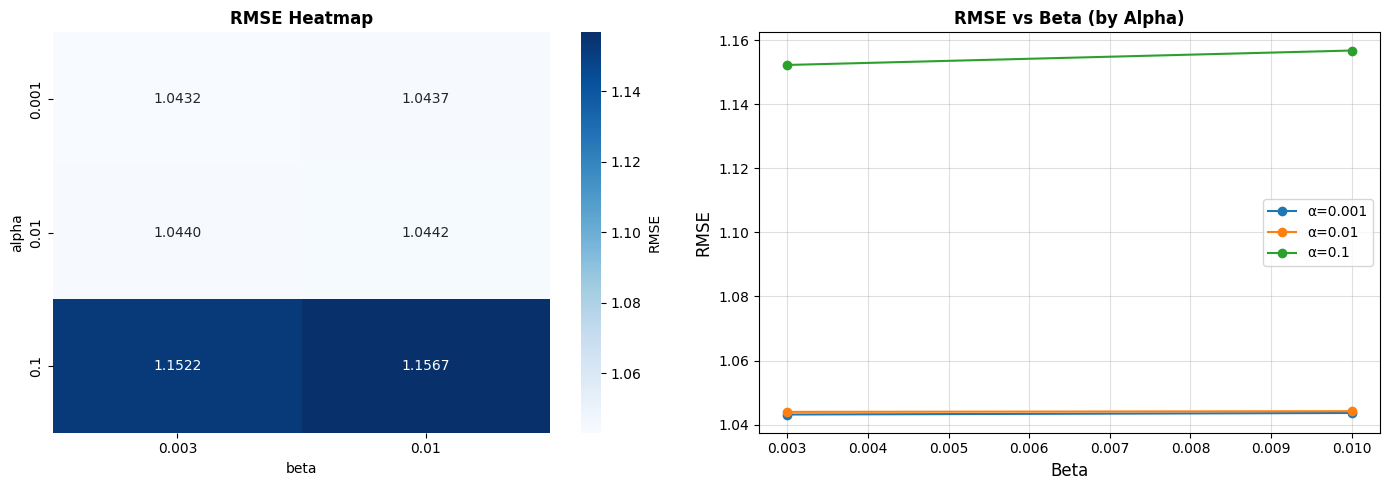

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# left: leatmap
pivot_table = results_df.pivot(index='alpha', columns='beta', values='rmse')
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='Blues', ax=axes[0], cbar_kws={'label': 'RMSE'})
axes[0].set_title('RMSE Heatmap', fontsize=12, fontweight='bold')

# line plot for each alpha, we can do a bigger gridsearch to make a better chart too
for alpha_val in results_df['alpha'].unique():
    subset = results_df[results_df['alpha'] == alpha_val].sort_values('beta')
    axes[1].plot(subset['beta'], subset['rmse'], marker='o', label=f'α={alpha_val}')

axes[1].set_xlabel('Beta', fontsize=12)
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('RMSE vs Beta (by Alpha)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.4)

plt.tight_layout()
plt.show()

In [ ]:
# Test model 2

In [ ]:
#### HP tuning round two, we saw a decent reduction in rmse when the lr was increased to 0.001
### Lower regularization also seemed to help

In [135]:
def evaluate_model_training(model):
    epochs = model.history["epoch"]
    rmse = model.history["train_rmse"]
    mae = model.history["train_mae"]

    plt.figure()
    plt.plot(epochs, rmse, label="Train RMSE")
    plt.plot(epochs, mae, label="Train MAE")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.title("Training Error over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

In [39]:
bm = HybridRecommender(
    n_factors=50,
    n_epochs=30,
    lr=0.005,
    reg=0.01,
    # user_features=user_features_prepared,
    # loc_features=business_features,
    user_feat_matrix=cached_user_matrix,
    loc_feat_matrix=cached_loc_matrix,
    alpha=1e-3,
    beta=1e-3)
bm.fit_and_track(trainset)

Elapsed time [prepare user and restaurant features]: 0m 0.01s


Elapsed time [fit recommender]: 12m 18.26s


In [40]:
predsbm = bm.test(testset)
res = evaluate_model(predsbm)
res

{'RMSE': 0.990364651872977,
 'MAE': 0.765383110114883,
 'Precision@5': 0.7731689790503566,
 'Recall@5': 0.5600880258419355,
 'Precision@10': 0.753215709293317,
 'Recall@10': 0.7262670042245789,
 'Precision@20': 0.7457337870034954,
 'Recall@20': 0.7879999470212278,
 'Precision@30': 0.744175168601486,
 'Recall@30': 0.7987782742813115,
 'Precision@50': 0.7435388664200561,
 'Recall@50': 0.8029721103344751}

In [ ]:
# Hybrid model at the beginning is the best

In [42]:
def plot_prediction_distribution(predictions):
    """Visualize prediction distribution vs actual ratings"""
    y_true = [pred.r_ui for pred in predictions]
    y_pred = [pred.est for pred in predictions]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # scatter plot
    axes[0, 0].scatter(y_true, y_pred, alpha=0.3, s=10)
    axes[0, 0].plot([1, 5], [1, 5], 'r--', linewidth=2)
    axes[0, 0].set_xlabel('Actual Rating', fontsize=12)
    axes[0, 0].set_ylabel('Predicted Rating', fontsize=12)
    axes[0, 0].set_title('Actual vs Predicted Ratings', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # 2 error distn
    errors = np.array(y_true) - np.array(y_pred)
    axes[0, 1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
    axes[0, 1].set_xlabel('Prediction Error', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].set_title('Prediction Error Distribution', fontsize=14, fontweight='bold')

    # 3. distn comparison
    axes[1, 0].hist(y_true, bins=20, alpha=0.5, label='Actual', edgecolor='black')
    axes[1, 0].hist(y_pred, bins=20, alpha=0.5, label='Predicted', edgecolor='black')
    axes[1, 0].set_xlabel('Rating', fontsize=12)
    axes[1, 0].set_ylabel('Frequency', fontsize=12)
    axes[1, 0].set_title('Rating Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].legend()

    # 4. error by rating
    rating_errors = pd.DataFrame({'actual': y_true, 'error': np.abs(errors)})
    rating_errors.groupby('actual')['error'].mean().plot(
        kind='bar', ax=axes[1, 1], color='steelblue', edgecolor='black')
    axes[1, 1].set_xlabel('Actual Rating', fontsize=12)
    axes[1, 1].set_ylabel('Mean Absolute Error', fontsize=12)
    axes[1, 1].set_title('MAE by Rating Level', fontsize=14, fontweight='bold')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

    plt.tight_layout()
    plt.show()


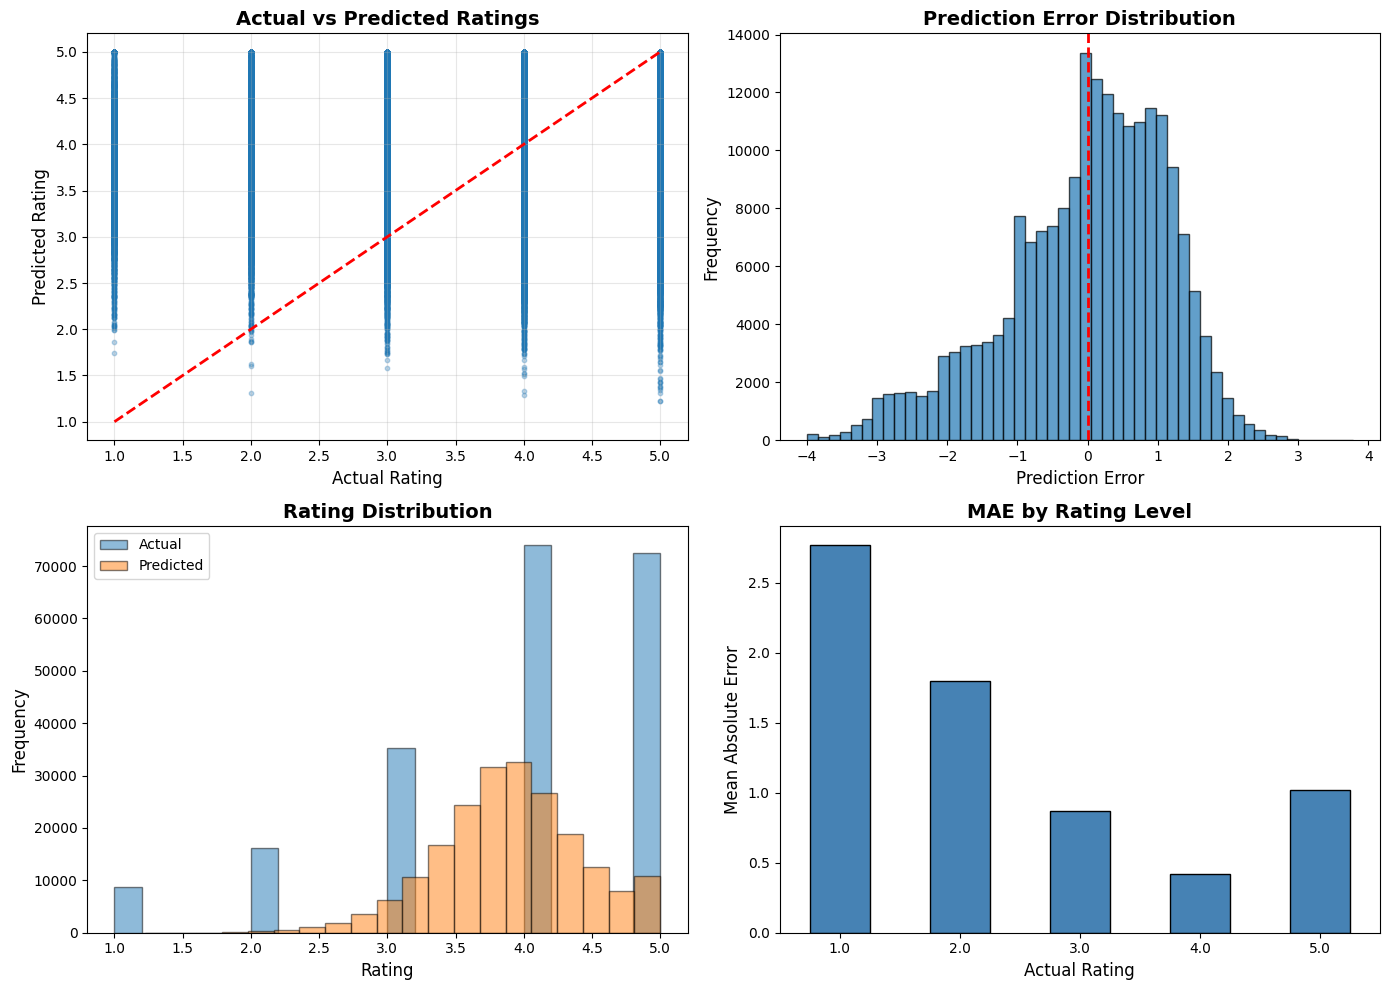

In [43]:
plot_prediction_distribution(preds)

In [44]:
def plot_precision_and_recall(results_dict):
    """Plot Precision@k and Recall@k from evaluation results"""
    ks = [5, 10, 20, 30, 50]
    precisions = [results_dict[f'Precision@{k}'] for k in ks]
    recalls = [results_dict[f'Recall@{k}'] for k in ks]

    plt.figure(figsize=(10, 6))
    plt.plot(ks, precisions, marker='o', label='Precision@k')
    plt.plot(ks, recalls, marker='o', label='Recall@k')
    plt.xlabel('k', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Precision and Recall at k', fontsize=14, fontweight='bold')
    plt.xticks(ks)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

Plot precision and rcall at different k vals

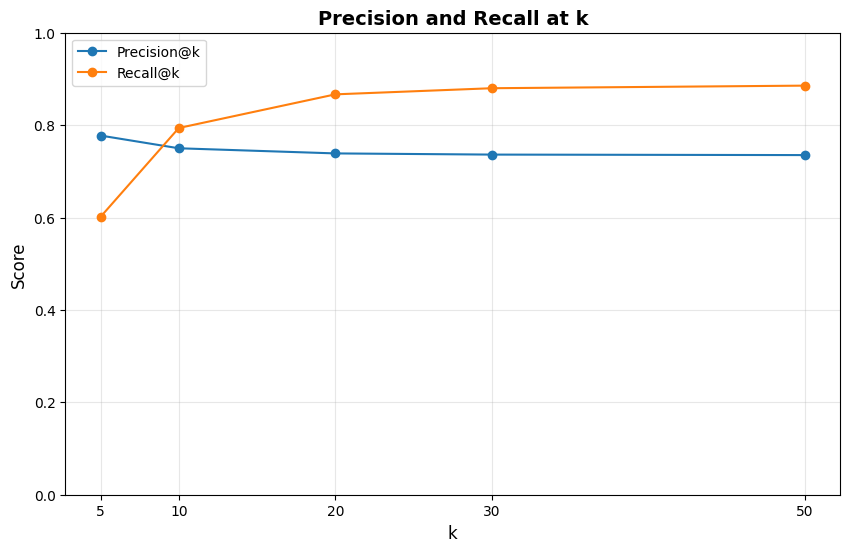

In [45]:
# r is the variable for the hybrid model metrics dict
plot_precision_and_recall(r)

In [46]:
import dill
# save the trained model
def save_model(model, filename='hybrid_recommender_model.pkl'):
    """Save the trained model to disk"""
    with open(filename, 'wb') as f:
        dill.dump(model, f)
    print(f"Model saved to {filename}")


# load a saved model
def load_model(filename='../final_model/hybrid_recommender.pkl'):
    """Load a trained model from disk"""
    with open(filename, 'rb') as f:
        model = dill.load(f)
    print(f"Model loaded from {filename}")
    return model

In [47]:
# save everything needed
print("Saving model and artifacts...")
save_model(hybrid, '../final_model/hybrid_recommender_v6.pkl')


Saving model and artifacts...
Model saved to ../final_model/hybrid_recommender_v6.pkl


In [48]:
with open('../final_model/user_features.pkl', 'wb') as f:
    dill.dump(user_features_prepared, f)

with open('../final_model/business_features.pkl', 'wb') as f:
    dill.dump(business_features, f)

In [49]:
with open('../final_model/filtered_business_df.pkl', 'wb') as f:
    dill.dump(filtered_business_df, f)

with open('../final_model/reviews_clean.pkl', 'wb') as f:
    dill.dump(reviews_clean, f)

In [ ]:
# with open('../final_model/reviews_clean.pkl', 'rb') as f:
#     reviews_clean = dill.(f)

In [51]:
def get_user_recommendations(model, reviews_df, user_id, n=10, min_rating=3.5):
    """
    Get top N recommendations for a user

    Parameters:
    - model: trained HybridRecommender
    - user_id: the user's ID
    - n: number of recommendations
    - min_rating: minimum predicted rating threshold

    Returns DataFrame with recommendations
    """
    # get all businesses
    all_businesses = business_features['business_id'].unique()

    # get businesses the user has already rated
    user_rated = reviews_df[reviews_df['user_id'] == user_id]['business_id'].unique()

    # get unrated businesses
    unrated_businesses = [b for b in all_businesses if b not in user_rated]

    # make predictions for all unrated businesses
    predictions = []
    for business_id in unrated_businesses:
        try:
            # convert to internal IDs
            inner_uid = model.trainset.to_inner_uid(user_id)
            inner_iid = model.trainset.to_inner_iid(business_id)

            # get prediction
            pred_rating = model.estimate(inner_uid, inner_iid)

            predictions.append({
                'business_id': business_id,
                'predicted_rating': pred_rating})
        except:
            # user or business not in training set
            continue

    # convert to df and filter
    recs_df = pd.DataFrame(predictions)
    recs_df = recs_df[recs_df['predicted_rating'] >= min_rating]
    recs_df = recs_df.sort_values('predicted_rating', ascending=False).head(n)

    # add business details
    recs_df = recs_df.merge(filtered_business_df[['business_id', 'name', 'city', 'state', 'stars', 'categories']], on='business_id', how='left')

    return recs_df

# test
sample_users = reviews_clean['user_id'].iloc[:3]
for sample_user in sample_users:
    recommendations = get_user_recommendations(hybrid, sample_user, n=10)
    print(f"\nTop 10 recommendations for user {sample_user}:")
    print(recommendations[['name', 'predicted_rating', 'city', 'categories']])
    print("\n" + "="*50 + "\n")


Top 10 recommendations for user smOvOajNG0lS4Pq7d8g4JQ:
                       name  predicted_rating              city  \
0           Blues City Deli          4.336395       Saint Louis   
1   Iovine Brothers Produce          4.328312      Philadelphia   
2            Angelo Brocato          4.270662       New Orleans   
3                  Tumerico          4.265541            Tucson   
4                    Laurel          4.240937      Philadelphia   
5  Desserts by Toffee to Go          4.240379             Tampa   
6                      Vida          4.223040      Indianapolis   
7                  Amelia’s          4.199799      Indianapolis   
8  Mazzaro's Italian Market          4.193347  Saint Petersburg   
9    Jeremiah's Italian Ice          4.190271             Tampa   

                                          categories  
0  Delis, Bars, Restaurants, Nightlife, Pubs, Ame...  
1             Fruits & Veggies, Food, Specialty Food  
2  Bakeries, Ice Cream & Frozen Yogurt, 

In [53]:
def get_batch_predictions(model, user_business_pairs):
    """
    Get predictions for multiple user-business pairs

    Parameters:
    - model: trained model
    - user_business_pairs: list of (user_id, business_id) tuples

    Returns DataFrame with predictions
    """
    results = []

    for user_id, business_id in user_business_pairs:
        try:
            inner_uid = model.trainset.to_inner_uid(user_id)
            inner_iid = model.trainset.to_inner_iid(business_id)
            pred_rating = model.estimate(inner_uid, inner_iid)

            results.append({
                'user_id': user_id,
                'business_id': business_id,
                'predicted_rating': pred_rating})
        except:
            results.append({
                'user_id': user_id,
                'business_id': business_id,
                'predicted_rating': None})

    return pd.DataFrame(results)


# example: get predictions for test set pairs
test_pairs = [(pred.uid, pred.iid) for pred in preds[:100]]
batch_preds = get_batch_predictions(hybrid, test_pairs)
print(batch_preds.head())

                  user_id             business_id  predicted_rating
0  N5fd36xJuEEHAHLHFirVCg  bbzD8rZl3i-NTzernYkxig          3.833593
1  PZc2H9Mn6Fp5QyAKRb6ybA  D4spXIMXev6pFUz3df31fQ          4.398785
2  Byog9k35hMURW_O1dIteHw  _m0mp3Wjcteysto6azQ9iA          4.514890
3  xmTidbmCE9nicKck13UyxA  W3x97_8QAXaUP8n_PW_g5g          4.010419
4  VgjDjhSzy8VMrlUTb4VIMA  SwWfW3vBn5QkDE7T3urGAg          4.203119


In [ ]:
def export_all_predictions(preds, output_file='predictions.csv'):
    """Export all test set predictions to CSV"""
    predictions_data = []

    for pred in preds:
        predictions_data.append({
            'user_id': pred.uid,
            'business_id': pred.iid,
            'actual_rating': pred.r_ui,
            'predicted_rating': pred.est,
            'prediction_error': pred.r_ui - pred.est})

    pred_df = pd.DataFrame(predictions_data)
    pred_df.to_csv(output_file, index=False)
    print(f"Predictions exported to {output_file}")

    return pred_df

# export predictions
pred_export = export_all_predictions(preds, '../output/test_predictions.csv')


In [ ]:
# later, load and use (old way, now everything is bundled in one pkl file
# print("\nLoading model...")
# loaded_model = load_model('../final_model/hybrid_recommender_v6.pkl')
#
# with open('../final_model/user_features.pkl', 'rb') as f:
#     user_features_prepared = pickle.load(f)
#
# with open('../final_model/business_features.pkl', 'rb') as f:
#     business_features = pickle.load(f)
#
# with open('../final_model/filtered_business_df.pkl', 'rb') as f:
#     filtered_business_df = pickle.load(f)
#
# with open('../final_model/reviews_clean.pkl', 'rb') as f:
#     reviews_loaded = pickle.load(f)
# # make new recommendations
# test_user = reviews_loaded['user_id'].iloc[10]
# new_recs = get_user_recommendations(loaded_model, test_user, n=5)
# print(new_recs)